<center><h1>Introduction to image processing - Color transfer</h1>

# Introduction
For the following exercices, you need Python 3 with some basic librairies (see below).
All images necessary for the session are available [here](https://github.com/judelo/notebooks/tree/master/im). 

If you use your own Python 3 install, you should download the images, put them in a convenient directory and update the path in the next cell.

For some parts of the session (cells with commands written as `todo_something`...), you are supposed to code by yourself.   

In [1]:
path = '../im/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as sd 

from time import time

In [3]:
# Optimal Transport library https://github.com/rflamary/POT
import ot    

The following line will be used to import the solutions of the practical session. Do not use it for the moment.

In [4]:
from TP_color_transfer import *

**Load and display a color image**. A color image is made of three channels : red, green and blue. A color image in $\mathbb{R}^{N\times M}$ is stored as a $N\times M\times 3$ matrix.


<span style="color:red">
    
**Be careful with the functions `plt.imread()` and `plt.imshow()` of `matplotlib`.** 
- `plt.imread()` reads png images as numpy arrays of floating points between 0 and 1, but it reads jpg or bmp images as numpy arrays of 8 bit integers. 

- **In this practical session, we assume floating point images between 0 and 1, so if you use jpg or bmp images, you should normalize them to $[0,1]$.** 

- If 'im' is an image encoded as a double numpy array, `plt.imshow(im)` will display all values above 1 in white and all values below 0 in black. If the image 'im' is encoded on 8 bits though, `plt.imshow(im)` will display 0 in black and 255 in white.</span>

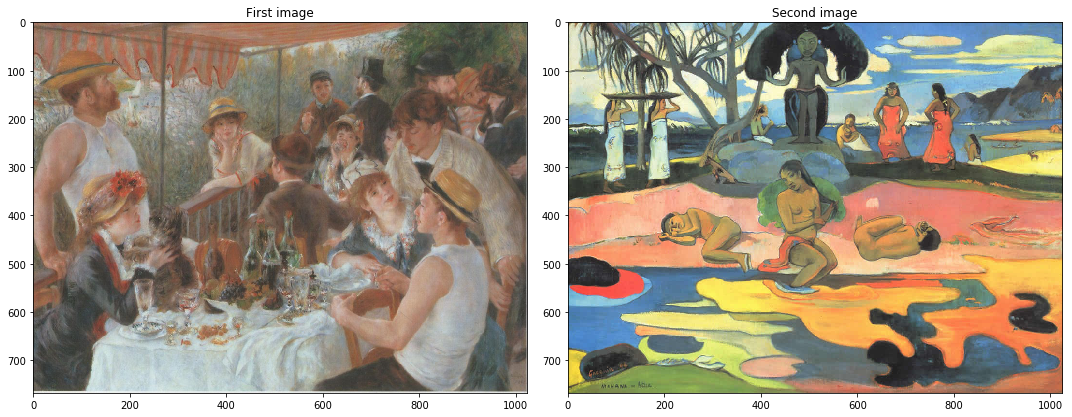

In [5]:
imrgb1 = plt.imread(path+'renoir.jpg')/255
imrgb2 = plt.imread(path+'gauguin.jpg')/255
imrgb1=imrgb1[:,:,0:3] # useful if the image is a png with a transparency channel
imrgb2=imrgb2[:,:,0:3] 

#we display the images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axes[0].imshow(imrgb1)
axes[0].set_title('First image')
axes[1].imshow(imrgb2)
axes[1].set_title('Second image')
fig.tight_layout()

In [247]:
u          = imrgb1
v          = imrgb2
s          = 8                            # choose s=10 or larger in your session!!!
if s==1:
        usubsample = u
        vsubsample = v
else:
        usubsample = u[1::s,1::s,0:3]
        vsubsample = v[1::s,1::s,0:3]
X          = usubsample.reshape((usubsample.shape[0]*usubsample.shape[1],3))
Y          = vsubsample.reshape((vsubsample.shape[0]*vsubsample.shape[1],3))

# Sinkhorn with POT, ne fonctionne pas pour une image trop grosse car stocke la matrice 

-> ok en divisant l'image par 16 dans chaque dimension, mais à 8 prend beaucoup de temps. Au delà, la mémoire n'est plus suffisante. 

In [248]:
n = X.shape[0]
a,b = np.ones((n,)) / n, np.ones((n,)) /n 
f,g = np.ones((n,)) / n, np.ones((n,)) /n 

# matrix of distances
M = np.sum(X**2,axis=1).reshape(n,1)@np.ones((1,n)) + np.ones((n,1))@np.sum(Y**2,axis=1).T.reshape(1,n) - 2*X@Y.T
#M /= M.max()

In [249]:
niter = 100
eps = 0.01
A = np.exp(-M/eps)

for t in range(niter):  
    a = f / (A@b)
    b = g / (A.T@a)

G0 = np.diag(a)@A@np.diag(b)


In [250]:
Z = Y[np.argmax(G0,axis=1)]

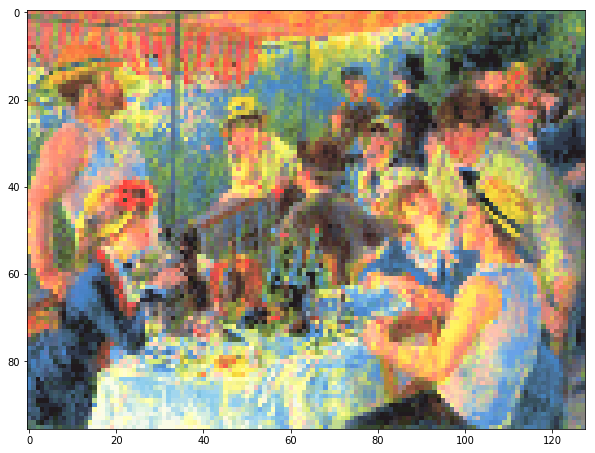

In [253]:
Zim = Z.reshape(usubsample.shape)
plt.figure(figsize=(10,10))
plt.imshow(Zim)

 # Sinkhorn with convolutions 
 on constate que ce n'est pas possible d'aller au dessus d'une certaine taille d'image car on ne peut pas stocker M
 on réimplémente Sinkhorn dans ce cas.



In [112]:
# sinkhorn 3D with convolutions
t1 = time()
niter = 20
N = 64
eps = 0.01

# probability vectors
u          = np.floor(np.double(imrgb1*(N-0.01)))
v          = np.floor(np.double(imrgb2*(N-0.01)))
f, g = np.zeros((N,N,N)), np.zeros((N,N,N))
for k in range(u.shape[0]):
    for j in range(u.shape[1]):
        f[int(u[k,j,:][0]),int(u[k,j,:][1]),int(u[k,j,:][2])]+=1
for k in range(v.shape[0]):
    for j in range(v.shape[1]):
        g[int(v[k,j,:][0]),int(v[k,j,:][1]),int(v[k,j,:][2])]+=1
        
        
f, g = f/np.sum(f), g/np.sum(g)       

a, b = np.ones((N,N,N)), np.ones((N,N,N))
a, b = a/np.sum(a), b/np.sum(b)       


# matrix version
#X,Y,Z,T,U,V = np.meshgrid(x,x,x,x,x,x)
#M = np.exp(-((X-T)**2+(Y-U)**2+(Z-V)**2)/(eps*N**2))
#M = M.reshape(N**3,N**3)
#alph,beta = np.copy(a).reshape(N**3,1),np.copy(b).reshape(N**3,1)

#for t in range(niter):  
#    alph = f.reshape(N**3,1) / M@beta
#    beta = g.reshape(N**3,1) / M.T@alph



# distance matrix and corresponding filter
h=np.zeros((2*N-1,))
x = np.linspace(0,N-1,N)
w = np.exp(-x**2/(N**2*eps)) 
h[N-1:2*N-1]=np.copy(w)
h[0:N-1]= w[N:0:-1]

for t in range(niter):
    Ab = sd.convolve(b,h.reshape(1,1,2*N-1),mode='constant')   
    Ab = sd.convolve(Ab,h.reshape(1,2*N-1,1),mode='constant') 
    Ab = sd.convolve(Ab,h.reshape(2*N-1,1,1),mode='constant')  
    a = f / Ab
    Aa = sd.convolve(a,h.reshape(1,1,2*N-1),mode='constant')
    Aa = sd.convolve(Aa,h.reshape(1,2*N-1,1),mode='constant')  
    Aa = sd.convolve(Aa,h.reshape(2*N-1,1,1),mode='constant') 
    b = g / Aa

t2 = time()
print(t2-t1) 
print('sinkhorn done')


6.883475065231323
sinkhorn done


27.47229313850403


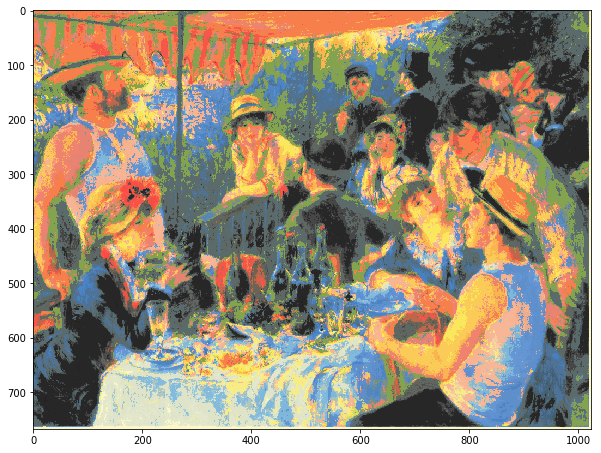

In [114]:
t1 = time()
x = np.linspace(0,N-1,N)
otmap =  np.zeros((N,N,N,3))

X = np.transpose(np.nonzero(f))
Y = np.transpose(np.nonzero(g))

for t in range(X.shape[0]):
    l,m,n = np.uint8(X[t,:])
    toto = np.exp(-((x.reshape(N,1,1)-l)**2+(x.reshape(1,N,1)-m)**2+(x.reshape(1,1,N)-n)**2)/(N**2*eps))*b
    l1,m1,n1 = np.unravel_index(np.argmax(toto, axis=None), toto.shape)
    otmap[l,m,n,:] = np.array([l1,m1,n1]) 
    
out = otmap[np.uint8(u[:,:,0]),np.uint8(u[:,:,1]),np.uint8(u[:,:,2]),:]

plt.figure(figsize = (10,10))
plt.imshow(out/N)
t2 = time()
print(t2-t1)



# Sinkhorn 1D entre deux signaux

In [146]:
# sinkhorn 1D
niter = 100
N = 10  
eps = 1

# probability vectors
a, b = np.ones((N,)), np.ones((N,))
a, b = a/np.sum(a), b/np.sum(b)       

# distance matrix
h=np.zeros((2*N-1,))
x = np.linspace(0,N-1,N)
x = np.exp(-x**2/(N**2*eps)) 
h[N-1:2*N-1]=x
h[0:N-1]= x[N:0:-1]

f,g = np.zeros((N,)), np.zeros((N,))
f[0] = 1
g[5] = 1
                                 
for t in range(niter):
    a = f / np.convolve(h,b,'valid')
    b = g / np.convolve(h,a,'valid')
X = np.diag(a.flatten())@A@np.diag(b.flatten())    
print(X)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Postprocessing: Regularization 

Before starting this part, if you have worked with subsampled images in the previous part, you can load the results of the color transfer on full images.

In [4]:
usubsample = plt.imread(path+'renoir.jpg')/255
wsliced    = plt.imread(path+'renoir_by_gauguin.png')
wsliced    = wsliced[:,:,0:3]                          # to remove transparency channel

A common drawback of classical methods aiming at color and contrast modifications is the revealing of artefacts (JPEG blocs, color inconsistancies, noise enhancement) or the attenuation of details and textures (see for instance the following [web page](http://perso.telecom-paristech.fr/~delon/artefact_removal_html/)). 
Let $u$ be an image and $g(u)$ the same  image after color or contrast modification, we write $\mathcal{M}(u) = g(u) - u$. All artefacts observable in $g(u)$ can be seen as irregularities in these difference map $\mathcal{M}(u)$. In order to reduce these artefacts, we propose to filter this difference map thanks to an operator $Y_u$ and to reconstruct the image:

$$T(g(u)) = u + Y_u(g(u)-u).$$

Let us begin with a very simple averaging filter for $Y_u$.

## Simple averaging filter on the difference map

A simple averaging filter can be implemented with the function `convolve2d` of `scipy.signal` for instance.  However, it is much more efficient to compute this average filter thanks to integral images, as follows.

In [5]:
def average_filter(u,r):
    # uniform filter with a square (2*r+1)x(2*r+1) window 
    # u is a 2d image
    # r is the radius for the filter
   
    (nrow, ncol)                                      = u.shape
    big_uint                                          = np.zeros((nrow+2*r+1,ncol+2*r+1))
    big_uint[r+1:nrow+r+1,r+1:ncol+r+1]               = u
    big_uint                                          = np.cumsum(np.cumsum(big_uint,0),1)       # integral image
        
    out = big_uint[2*r+1:nrow+2*r+1,2*r+1:ncol+2*r+1] + big_uint[0:nrow,0:ncol] - big_uint[0:nrow,2*r+1:ncol+2*r+1] - big_uint[2*r+1:nrow+2*r+1,0:ncol]
    out = out/(2*r+1)**2
    
    return out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


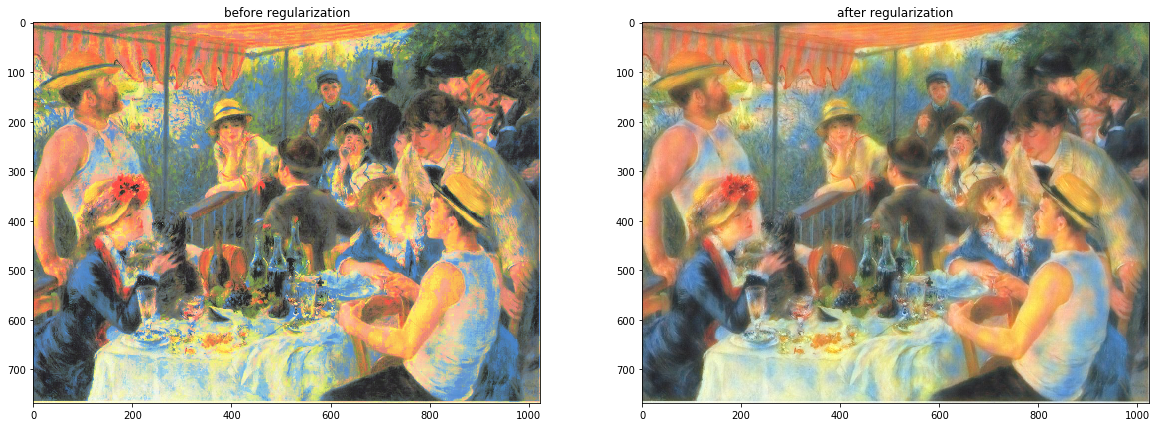

In [6]:
diff = wsliced-usubsample
out = np.zeros_like(usubsample)
r=10
for i in range(3):
    out[:,:,i] = average_filter(diff[:,:,i], r)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(wsliced)
axes[0].set_title('before regularization')
axes[1].set_title('after regularization')
axes[1].imshow(usubsample+out)

Let's zoom on the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


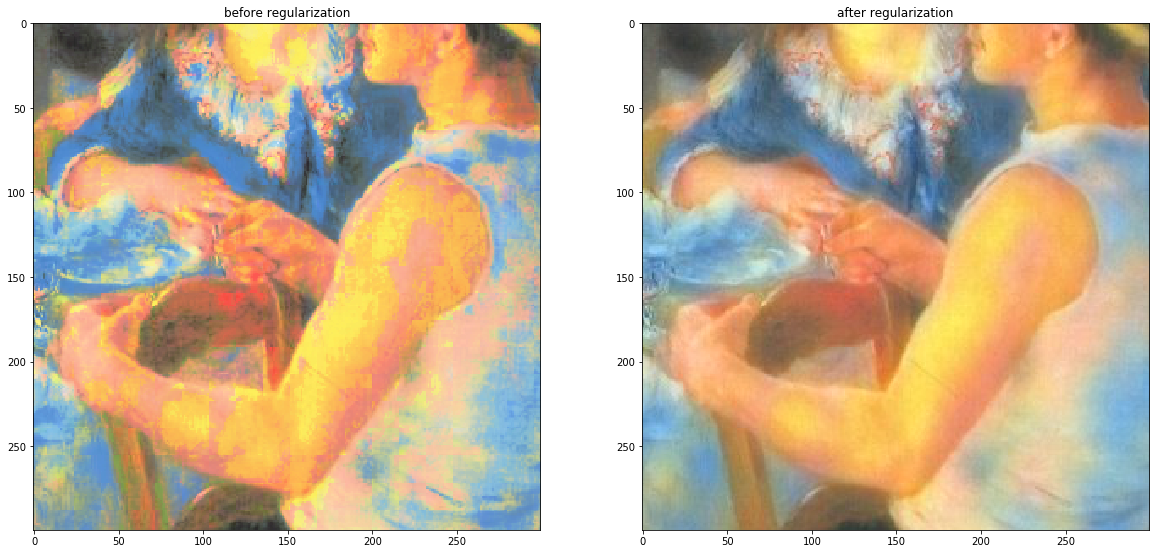

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(wsliced[400:700,600:900,:])
axes[0].set_title('before regularization')
axes[1].set_title('after regularization')
axes[1].imshow(usubsample[400:700,600:900,:]+out[400:700,600:900,:])

The result is not bad but some blur appears and is due to the fact that the edges in the image `out` do not coincide anymore with the edges in the original image. 

## Guided filter on the difference map

A more interesting result can be obtained by guiding the filtering of the difference map $\mathcal{M}(u)$ in a way such that it will follow the regularity of $u$. 
To this aim, we define the operator $Y_u$ as the guided filter described in the paper

[*Guided Image Filtering*, Kaiming He1, Jian Sun2, and Xiaoou Tang, ECCV 2010.](http://kaiminghe.com/publications/eccv10guidedfilter.pdf)


The idea is the following: let $u$ be an image that we want to regularize, and $guide$ be a guidance image of the same size. We want to construct an output image $q$ which looks like $u$ but follows the regularity of $guide$. To this aim, we will try to ensure that the gradient of $q$ is (almost) proportional to the gradient of $guide$. The algorithm is as follows (see page 4 of the aforementioned paper):

1. For each pixel $k$ of $u$, let $\omega_k$ be a square window centered at pixel $k$, we look for coefficients $a_k$ and $b_k$ which minimizes the euclidean distance between $u$ and the linear transform $q = a_k guide + b_k$ on the square $\omega_k$. The solution is given by linear regression, i.e. 

$$a_k = \frac{\frac{1}{|\omega_k|}\sum_{i\in \omega_k} guide(i)u(i) - \mathrm{mean}(u)_k \mathrm{mean}(guide)_k}{\sigma(guide)_k^2}$$
$$b_k =  \mathrm{mean}(u)_k-a_k \mathrm{mean}(guide)_k$$

where $\mathrm{mean}(guide)_k$ is the average value of the image $guide$ on the square $\omega_k$ and $\sigma(guide)_k^2$ is the empirical variance of $guide$ on $\omega_k$, i.e

$$\sigma(guide)_k^2 = \frac{1}{|\omega_k|}\left(\sum_{i\in \omega_k} guide(i)^2 - \mathrm{mean}(guide)_k\right).  $$

2. The previous step yields a grid of linear coefficients $(a_k,b_k)$. Since each pixel $k$ belongs to several windows, we average these coefficients on each window $\omega$ to obtain new coefficients $(\bar{a}_k,\bar{b}_k)$, and the final image is obtained as

$$q(k) = \bar{a}_k guide(k) + \bar{b}_k.$$


- **Write a function `todo_guided_filter` which computes the filter described above.** The function should take as input two gray level images $u$ and $guide$, an integer $r$ and a regularization parameter $\epsilon$, and should ouput a gray level image. **Everything can be implemented without `for` loops**, with 2D convolutions (function `convolve2d` of `scipy.signal`) or much more efficiently with the $O(1)$ `average_filter` function using integral images that we defined above.  
  
- Apply the previous filter to $\mathcal{M}(u)$ and display the result $T(g(u))$. You can use $\epsilon = 10^{-4}$ and $r=20$ for instance.

In [72]:
diff = out - u
out2 = np.zeros_like(u)

for i in range(3):
    out2[:,:,i] = todo_guided_filter(diff[:,:,i], u[:,:,i], 20,1e-4 )

We display the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


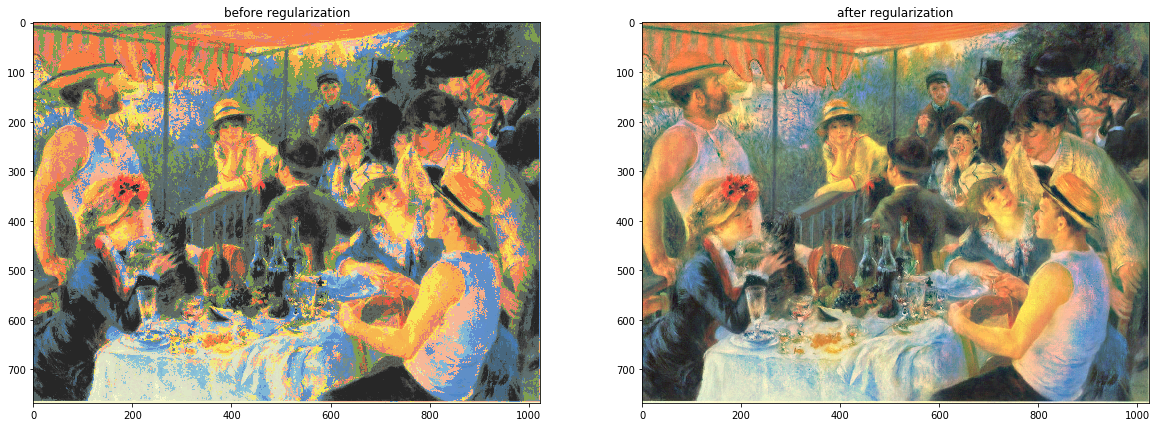

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(out)
axes[0].set_title('before regularization')
axes[1].set_title('after regularization')
axes[1].imshow(out2+u)

Zoom on the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


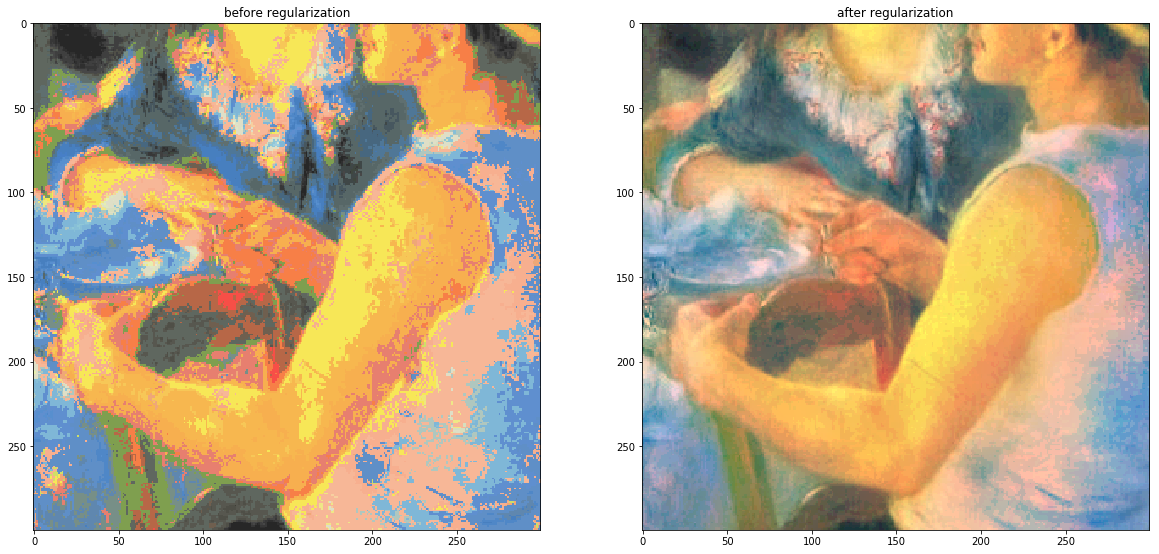

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(out[400:700,600:900,:])
axes[0].set_title('before regularization')
axes[1].set_title('after regularization')
axes[1].imshow(u[400:700,600:900,:]+out2[400:700,600:900,:])

## Barycenter and midway

Knowing the optimal (or an approximation) assignment between the point clouds $X$ and $Y$, you can compute barycenters between these discrete distributions. Hence you can compute the midway color distributions of a set of images.